In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


In [3]:
# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [4]:
# file paths for the imputed pca+metadata csvs created earlier
train_csv = "/Users/dana/Desktop/AHI/01_PAML/Project/scr/Part_2/train_pca_data_imputed.csv"
val_csv   = "/Users/dana/Desktop/AHI/01_PAML/Project/scr/Part_2/val_pca_data_imputed.csv"   # optional: not required by this script
test_csv  = "/Users/dana/Desktop/AHI/01_PAML/Project/scr/Part_2/test_pca_data_imputed.csv"

In [5]:
# choose the target column here; to adapt to other targets just change this variable
target_col = "er" # options: "er", "relapse", "node", "grade", or for regression "size"

In [6]:
# whether to treat target as classification (True) or regression (False)
# this script focuses on classification; set to False if using size as regression (see notes below)
is_classification = True

In [7]:
df_train = pd.read_csv(train_csv)
df_test  = pd.read_csv(test_csv)

In [32]:
df_test['er'].value_counts()

er
1.0    52
0.0    10
Name: count, dtype: int64

In [8]:
# basic safety checks
assert target_col in df_train.columns, f"target {target_col} not in train csv"
assert target_col in df_test.columns, f"target {target_col} not in test csv"

In [9]:
# features are all columns except the target
feature_cols = [c for c in df_train.columns if c != target_col]

In [10]:
# separate X / y
X_train = df_train[feature_cols].values
y_train = df_train[target_col].values
X_test  = df_test[feature_cols].values
y_test  = df_test[target_col].values

In [17]:
len(X_train)

184

In [16]:
len(X_test)

62

In [18]:
# if target is not integer-coded, convert to integer labels for classification
if is_classification:
    # convert to integer numpy array if not already
    if y_train.dtype.kind not in ("i", "u", "b"):
        y_train = pd.factorize(y_train)[0]
        y_test  = pd.factorize(y_test)[0]

In [19]:
def evaluate_and_report(name, model, X_test, y_test):
    """
    evaluate a fitted classifier on test set and print + return metrics
    """
    # predict probabilities if available for roc_auc
    y_pred = model.predict(X_test)
    results = {}
    results['accuracy'] = accuracy_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred, zero_division=0)
    results['recall'] = recall_score(y_test, y_pred, zero_division=0)
    results['f1'] = f1_score(y_test, y_pred, zero_division=0)

    # try roc_auc if binary classification and probabilities available
    if is_classification:
        try:
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
                results['roc_auc'] = roc_auc_score(y_test, y_prob)
            elif hasattr(model, "decision_function"):
                y_score = model.decision_function(X_test)
                results['roc_auc'] = roc_auc_score(y_test, y_score)
            else:
                results['roc_auc'] = np.nan
        except Exception:
            results['roc_auc'] = np.nan

    # print nice summary
    print(f"\n=== evaluation: {name} ===")
    for k, v in results.items():
        print(f"{k:10s}: {v:.4f}")
    print("\nclassification report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    return results, y_pred

In [ ]:
# model definitions & hyperparameter grids

In [ ]:
# imblearn's Pipeline so sampling occurs inside CV folds (no leakage)
# base samplers
smote = SMOTE(random_state=RANDOM_SEED)

# logistic regression pipeline with optional smote
pipe_lr_smote = ImbPipeline([("sampler", smote), ("clf", LogisticRegression(solver="liblinear", random_state=RANDOM_SEED, max_iter=2000))])

# logistic with no smote but class_weight balanced (set via grid)
pipe_lr_cw = ImbPipeline([("sampler", None),("clf", LogisticRegression(solver="liblinear", random_state=RANDOM_SEED, max_iter=2000, class_weight="balanced"))])

# random forest with smote
pipe_rf_smote = ImbPipeline([("sampler", smote),("clf", RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1))])

# random forest with class_weight balanced_subsample
pipe_rf_cw = ImbPipeline([("sampler", None),("clf", RandomForestClassifier(random_state=RANDOM_SEED, class_weight="balanced_subsample", n_jobs=-1))])

In [23]:
# create a dictionary of pipelines to gridsearch
pipelines = {
    "lr_smote": (pipe_lr_smote, {
        "clf__C": [0.01, 0.1, 1.0, 10.0],
        "clf__penalty": ["l1", "l2"]}),
    "lr_cw": (pipe_lr_cw, {
        "clf__C": [0.01, 0.1, 1.0, 10.0],
        "clf__penalty": ["l1", "l2"]}),
    "rf_smote": (pipe_rf_smote, {
        "clf__n_estimators": [200, 500],
        "clf__max_depth": [5, 10, None],}),
    "rf_cw": (pipe_rf_cw, {
        "clf__n_estimators": [200, 500],
        "clf__max_depth": [5, 10, None],})
}

In [24]:
# cross-validation and gridsearch setup

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

scoring = {
    "f1": "f1",
    "roc_auc": "roc_auc"
}

In [35]:
# store best models and results
best_models = {}
model_summaries = {}

for name, (pipeline, param_grid) in pipelines.items():
    # create gridsearch object
    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring="f1",                 # primary metric for imbalanced binary classification
        cv=cv,
        n_jobs=-1,
        verbose=1,
        refit=True
    )

    # fit gridsearch on training data (sampler inside pipeline ensures sampling occurs inside CV fold)
    print(f"\nrunning gridsearch for: {name}")
    gs.fit(X_train, y_train)

    # record best estimator and cv results
    best_models[name] = gs.best_estimator_
    model_summaries[name] = {
        "best_params": gs.best_params_,
        "best_cv_score_f1": gs.best_score_,
        "cv_results": gs.cv_results_
    }
    print(f"best f1 (cv) for {name}: {gs.best_score_:.4f}")
    print(f"best params for {name}: {gs.best_params_}")


running gridsearch for: lr_smote
Fitting 5 folds for each of 8 candidates, totalling 40 fits
best f1 (cv) for lr_smote: 0.7418
best params for lr_smote: {'clf__C': 1.0, 'clf__penalty': 'l2'}

running gridsearch for: lr_cw
Fitting 5 folds for each of 8 candidates, totalling 40 fits
best f1 (cv) for lr_cw: 0.7706
best params for lr_cw: {'clf__C': 10.0, 'clf__penalty': 'l2'}

running gridsearch for: rf_smote
Fitting 5 folds for each of 6 candidates, totalling 30 fits
best f1 (cv) for rf_smote: 0.6972
best params for rf_smote: {'clf__max_depth': 10, 'clf__n_estimators': 500}

running gridsearch for: rf_cw
Fitting 5 folds for each of 6 candidates, totalling 30 fits
best f1 (cv) for rf_cw: 0.6695
best params for rf_cw: {'clf__max_depth': 5, 'clf__n_estimators': 200}


In [36]:
# evaluate best models on held-out test set
overall_results = {}
predictions = {}

for name, model in best_models.items():
    results, y_pred = evaluate_and_report(name, model, X_test, y_test)
    overall_results[name] = results
    predictions[name] = y_pred


=== evaluation: lr_smote ===
accuracy  : 0.8387
precision : 0.5000
recall    : 0.6000
f1        : 0.5455
roc_auc   : 0.8673

classification report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        52
           1       0.50      0.60      0.55        10

    accuracy                           0.84        62
   macro avg       0.71      0.74      0.72        62
weighted avg       0.85      0.84      0.84        62


=== evaluation: lr_cw ===
accuracy  : 0.8871
precision : 0.6667
recall    : 0.6000
f1        : 0.6316
roc_auc   : 0.8577

classification report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        52
           1       0.67      0.60      0.63        10

    accuracy                           0.89        62
   macro avg       0.80      0.77      0.78        62
weighted avg       0.88      0.89      0.88        62


=== evaluation: rf_smote ===
accuracy  : 0.8871
pr

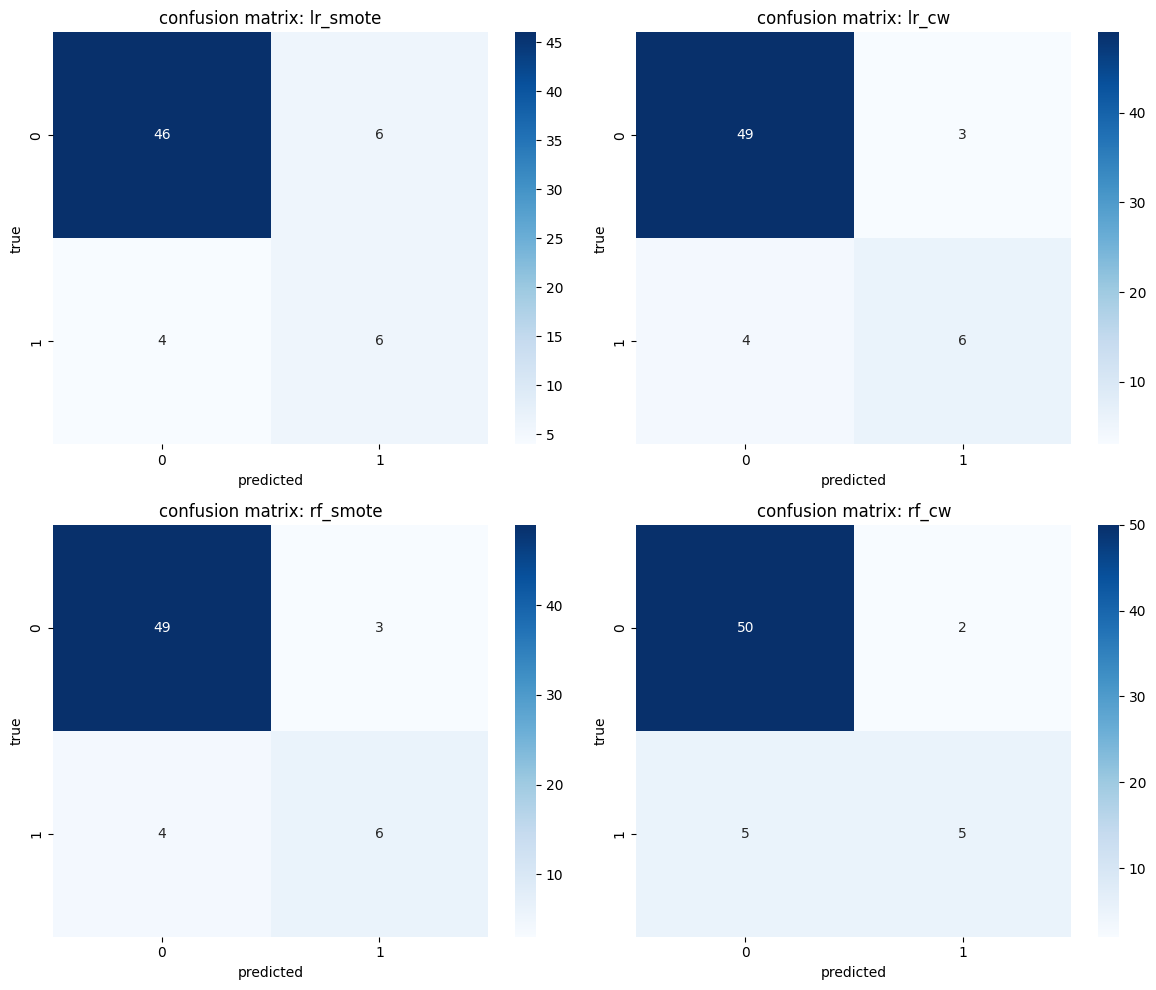

In [37]:
# confusion matrix plots for each best model
n_models = len(best_models)
ncols = 2
nrows = int(np.ceil((n_models) / ncols))

plt.figure(figsize=(6 * ncols, 5 * nrows))
for i, (name, y_pred) in enumerate(predictions.items(), 1):
    cm = confusion_matrix(y_test, y_pred)
    ax = plt.subplot(nrows, ncols, i)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"confusion matrix: {name}")
    ax.set_xlabel("predicted")
    ax.set_ylabel("true")
plt.tight_layout()
plt.show()

In [38]:
# compare models and pick "best" by f1 (or roc_auc)
summary_rows = []
for name, metrics in overall_results.items():
    summary_rows.append({
        "model": name,
        "accuracy": metrics.get("accuracy", np.nan),
        "precision": metrics.get("precision", np.nan),
        "recall": metrics.get("recall", np.nan),
        "f1": metrics.get("f1", np.nan),
        "roc_auc": metrics.get("roc_auc", np.nan)})

In [39]:
df_summary = pd.DataFrame(summary_rows).sort_values("f1", ascending=False).reset_index(drop=True)
print("\nmodels summary (sorted by f1)")
print(df_summary)

best_model_name = df_summary.loc[0, "model"]
print(f"\nbest model by f1: {best_model_name}")
print("best model details:", model_summaries[best_model_name])


models summary (sorted by f1)
      model  accuracy  precision  recall        f1   roc_auc
0     lr_cw  0.887097   0.666667     0.6  0.631579  0.857692
1  rf_smote  0.887097   0.666667     0.6  0.631579  0.926923
2     rf_cw  0.887097   0.714286     0.5  0.588235  0.950000
3  lr_smote  0.838710   0.500000     0.6  0.545455  0.867308

best model by f1: lr_cw
best model details: {'best_params': {'clf__C': 10.0, 'clf__penalty': 'l2'}, 'best_cv_score_f1': np.float64(0.7706060606060606), 'cv_results': {'mean_fit_time': array([0.00116005, 0.00128946, 0.00117426, 0.00148726, 0.00151587,
       0.00140958, 0.00252485, 0.00156174]), 'std_fit_time': array([0.00016268, 0.0001167 , 0.000141  , 0.00053082, 0.00049085,
       0.00034132, 0.00084913, 0.00016526]), 'mean_score_time': array([0.00117869, 0.00122237, 0.00109134, 0.00144706, 0.00133114,
       0.00107927, 0.0010788 , 0.00107126]), 'std_score_time': array([1.11232363e-04, 1.01308428e-04, 7.04409054e-05, 7.95029045e-04,
       5.77054105e-

In [ ]:
# add evaluation